# h_mean Autocorrelation: Why Does the Centroid Drift in a Straight Line?

**Question:** We know from `centroid_dynamics.ipynb` that the dead token centroid drifts in a highly correlated direction (consecutive displacement vectors have cosine similarity ≈ 0.99). We know from `lore/dead-token-dynamics.ipynb` that dead tokens move antiparallel to h_mean at each step.

**Hypothesis:** If h_mean[t] maintains a consistent direction over training steps (high autocorrelation), that would explain the straight-line centroid drift.

**This notebook:** Run 10 Crucible training steps and measure:

1. **h_mean[t] autocorrelation:** Does h_mean point in a consistent direction over time?
2. **delta_centroid[t] autocorrelation:** Confirm the 0.99 signal from centroid_dynamics
3. **h_mean[t] vs delta_centroid[t]:** Does h_mean predict centroid motion direction?
4. **Individual token alignment:** How tightly does each token's displacement align with h_mean?
5. **Token-to-token coherence:** How similar are individual token displacements to each other?
6. **Swarm coherence over time:** Does internal alignment change as training progresses?

---

## Setup

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer
from safetensors.torch import load_file
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from tqdm import tqdm

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


In [26]:
# Parameters (identical to Crucible 1 & 2)
RANDOM_SEED = 42
VOCAB_SIZE = 10000
HIDDEN_DIM = 64
NUM_LAYERS = 2
NUM_HEADS = 2
SEQ_LEN = 128
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.0
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8

NUM_STEPS = 10  # Number of training steps to analyze

# Paths - notebook runs from exploration/, need to go up 3 levels to project root
PROJECT_ROOT = Path.cwd().parent.parent.parent
CORPUS_PATH = PROJECT_ROOT / 'box_4' / 'data' / 'flannel_model_corpus.txt'
TOKENIZER_PATH = PROJECT_ROOT / 'box_4' / 'data' / 'flannel_tokenizer_chars.json'
DEAD_MASK_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Flannel' / 'live_dead_tokens.safetensors'

# Style
plt.rcParams['figure.dpi'] = 200
STEELBLUE = '#4682B4'

print(f"Crucible architecture: {VOCAB_SIZE} tokens, {HIDDEN_DIM}D, {NUM_LAYERS} layers, {NUM_HEADS} heads")
print(f"Training: lr={LEARNING_RATE}, AdamW (β₁={BETA1}, β₂={BETA2}, ε={EPSILON})")
print(f"Steps to analyze: {NUM_STEPS}")

Crucible architecture: 10000 tokens, 64D, 2 layers, 2 heads
Training: lr=0.001, AdamW (β₁=0.9, β₂=0.999, ε=1e-08)
Steps to analyze: 10


In [27]:
# Set random seeds
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

if device == 'cuda':
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"Random seed: {RANDOM_SEED}")

Random seed: 42


## Load Tokenizer and Dead Token Mask

In [28]:
tokenizer = Tokenizer.from_file(str(TOKENIZER_PATH))
print(f"Tokenizer vocab size: {tokenizer.get_vocab_size()}")

masks = load_file(str(DEAD_MASK_PATH))
dead_mask = masks['dead_mask'].bool()
dead_indices = masks['dead_indices'].long()
n_dead = dead_mask.sum().item()

print(f"Dead tokens: {n_dead}")
print(f"Live tokens: {VOCAB_SIZE - n_dead}")

Tokenizer vocab size: 10000
Dead tokens: 3699
Live tokens: 6301


## Dataset

In [29]:
class TextDataset(Dataset):
    def __init__(self, corpus_path, tokenizer, seq_len):
        with open(corpus_path, 'r', encoding='utf-8') as f:
            text = f.read()
        encoding = tokenizer.encode(text)
        self.tokens = encoding.ids
        self.seq_len = seq_len
        self.n_sequences = len(self.tokens) // seq_len
        
    def __len__(self):
        return self.n_sequences
    
    def __getitem__(self, idx):
        start = idx * self.seq_len
        chunk = self.tokens[start:start + self.seq_len]
        return torch.tensor(chunk, dtype=torch.long)

dataset = TextDataset(CORPUS_PATH, tokenizer, SEQ_LEN)
print(f"Dataset: {len(dataset)} sequences of length {SEQ_LEN}")

# Create dataloader with same shuffle seed
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

# Convert to iterator for step-by-step access
data_iter = iter(dataloader)
print(f"Dataloader ready")

Dataset: 10713 sequences of length 128
Dataloader ready


## Model Definition

In [30]:
class TinyLM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_layers, num_heads, seq_len):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.pos_embedding = nn.Embedding(seq_len, hidden_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=0.0,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln_f = nn.LayerNorm(hidden_dim)
        
        # Initialization (same as Crucible)
        nn.init.normal_(self.embedding.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.pos_embedding.weight, mean=0.0, std=0.02)
        
    def forward(self, input_ids, return_hidden=False):
        """If return_hidden=True, returns (logits, h) where h is the final hidden state."""
        batch_size, seq_len = input_ids.shape
        
        tok_emb = self.embedding(input_ids)
        pos_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        pos_emb = self.pos_embedding(pos_ids)
        
        hidden = tok_emb + pos_emb
        causal_mask = nn.Transformer.generate_square_subsequent_mask(seq_len, device=input_ids.device)
        hidden = self.transformer(hidden, mask=causal_mask, is_causal=True)
        hidden = self.ln_f(hidden)  # This is h
        
        logits = hidden @ self.embedding.weight.T
        
        if return_hidden:
            return logits, hidden
        return logits

model = TinyLM(VOCAB_SIZE, HIDDEN_DIM, NUM_LAYERS, NUM_HEADS, SEQ_LEN)
model = model.to(device).to(torch.bfloat16)

print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

Model initialized with 748,288 parameters


/Users/jefferyharrell/Projects/Azimuth_II/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [31]:
# Initialize optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(BETA1, BETA2),
    eps=EPSILON,
    weight_decay=WEIGHT_DECAY
)

print(f"Optimizer: AdamW(lr={LEARNING_RATE}, β₁={BETA1}, β₂={BETA2}, ε={EPSILON})")

Optimizer: AdamW(lr=0.001, β₁=0.9, β₂=0.999, ε=1e-08)


---

## Training Step Function

In [32]:
def training_step(model, batch, optimizer, dead_mask):
    """
    Run one training step and return measurements.
    
    Returns:
        h_mean: Mean hidden state over batch and sequence [D]
        delta_W: Displacement of dead tokens [n_dead, D]
        loss: Scalar loss value
    """
    # Capture W before update
    W_before = model.embedding.weight.detach().cpu()[dead_mask].to(torch.bfloat16).float()
    
    # Forward pass with hidden state extraction
    model.train()
    optimizer.zero_grad()
    
    input_ids = batch.to(device)
    
    with torch.autocast(device_type=device if device != 'mps' else 'cpu', dtype=torch.bfloat16):
        logits, h = model(input_ids, return_hidden=True)
        
        # Next-token prediction loss
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()
        
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(shift_logits.view(-1, VOCAB_SIZE), shift_labels.view(-1))
    
    # Backward and optimizer step
    loss.backward()
    optimizer.step()
    
    # Extract h_mean (averaged over batch and sequence)
    h_mean = h.mean(dim=(0, 1)).cpu().float()  # [D]
    
    # Capture W after update
    W_after = model.embedding.weight.detach().cpu()[dead_mask].to(torch.bfloat16).float()
    
    # Compute displacement
    delta_W = W_after - W_before  # [n_dead, D]
    
    return h_mean, delta_W, loss.item()

print("✓ Training step function defined")

✓ Training step function defined


---

## Run Training Steps and Collect Data

In [33]:
# Storage for measurements
h_means = []           # h_mean[t] for each step, shape [num_steps, D]
delta_Ws = []          # delta_W[t] for each step, shape [num_steps, n_dead, D]
centroids = []         # Centroid position at each step (cumulative)
delta_centroids = []   # Centroid displacement at each step
losses = []            # Loss at each step

# Initial centroid (t=0)
W_initial = model.embedding.weight.detach().cpu()[dead_mask].to(torch.bfloat16).float()
centroid_t = W_initial.mean(dim=0)  # [D]
centroids.append(centroid_t)

print(f"Running {NUM_STEPS} training steps...\n")

for step in tqdm(range(NUM_STEPS), desc="Training"):
    # Get next batch
    try:
        batch = next(data_iter)
    except StopIteration:
        # Reinitialize iterator if we run out of data
        data_iter = iter(dataloader)
        batch = next(data_iter)
    
    # Run training step
    h_mean, delta_W, loss = training_step(model, batch, optimizer, dead_mask)
    
    # Store measurements
    h_means.append(h_mean)
    delta_Ws.append(delta_W)
    losses.append(loss)
    
    # Compute centroid displacement
    delta_centroid = delta_W.mean(dim=0)  # [D]
    delta_centroids.append(delta_centroid)
    
    # Update cumulative centroid position
    centroid_t = centroid_t + delta_centroid
    centroids.append(centroid_t)

# Convert to tensors for analysis
h_means = torch.stack(h_means)  # [num_steps, D]
delta_Ws = torch.stack(delta_Ws)  # [num_steps, n_dead, D]
delta_centroids = torch.stack(delta_centroids)  # [num_steps, D]
centroids = torch.stack(centroids)  # [num_steps+1, D]

print(f"\n✓ Training complete")
print(f"h_means shape: {h_means.shape}")
print(f"delta_Ws shape: {delta_Ws.shape}")
print(f"delta_centroids shape: {delta_centroids.shape}")

Running 10 training steps...



Training: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


✓ Training complete
h_means shape: torch.Size([10, 64])
delta_Ws shape: torch.Size([10, 3699, 64])
delta_centroids shape: torch.Size([10, 64])


---

# Analysis

## 1. h_mean Autocorrelation

Does h_mean maintain a consistent direction over time?

In [34]:
# Compute cosine similarity between consecutive h_mean vectors
def cosine_similarity(a, b):
    """Cosine similarity between two vectors."""
    return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

h_autocorr = torch.zeros(NUM_STEPS - 1)
for t in range(NUM_STEPS - 1):
    h_autocorr[t] = cosine_similarity(h_means[t], h_means[t+1])

print("h_mean autocorrelation (consecutive steps):")
print(f"  Mean: {h_autocorr.mean().item():.6f}")
print(f"  Std: {h_autocorr.std().item():.6f}")
print(f"  Min: {h_autocorr.min().item():.6f}")
print(f"  Max: {h_autocorr.max().item():.6f}")

h_mean autocorrelation (consecutive steps):
  Mean: 0.946846
  Std: 0.127315
  Min: 0.609453
  Max: 0.998463


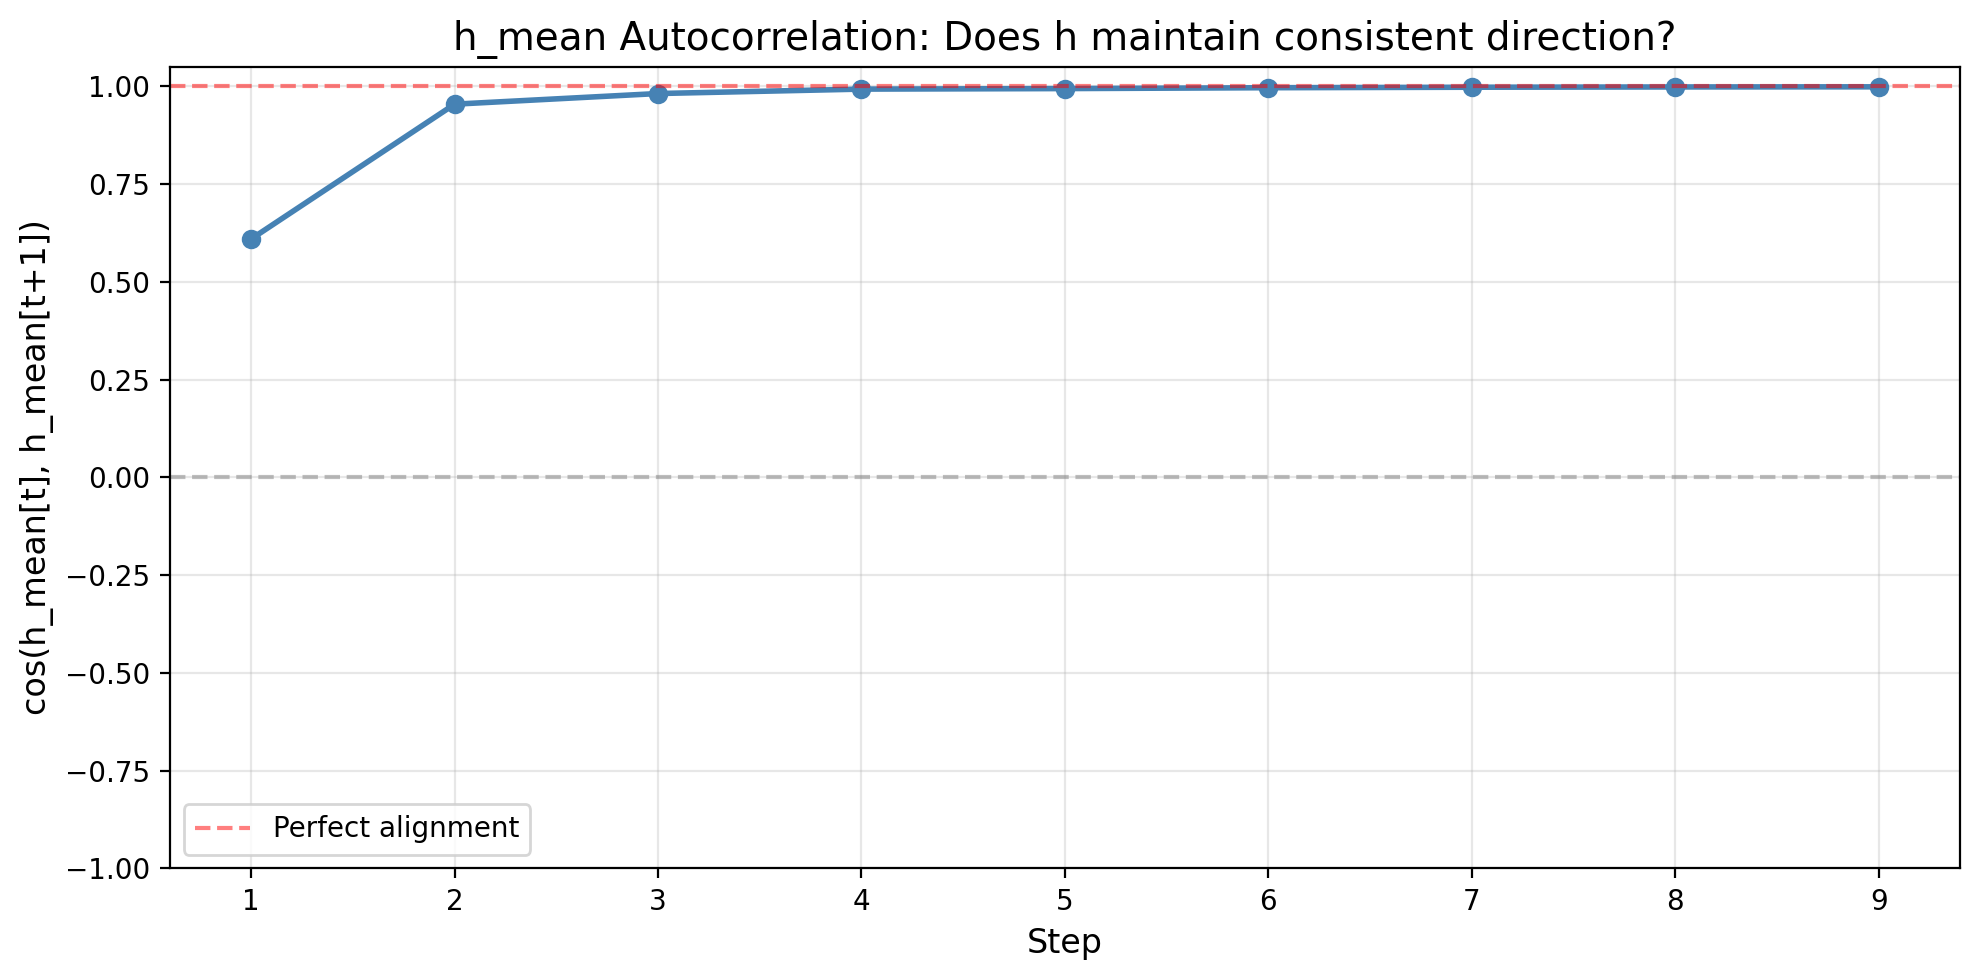

In [35]:
# Plot h_mean autocorrelation
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(1, NUM_STEPS), h_autocorr.detach().numpy(), 'o-', color=STEELBLUE, linewidth=2, markersize=6)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Perfect alignment')
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('cos(h_mean[t], h_mean[t+1])', fontsize=12)
ax.set_title('h_mean Autocorrelation: Does h maintain consistent direction?', fontsize=14)
ax.set_ylim(-1, 1.05)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 2. Delta Centroid Autocorrelation

Confirm the straight-line drift signal from `centroid_dynamics.ipynb`.

In [36]:
# Compute cosine similarity between consecutive centroid displacements
centroid_autocorr = torch.zeros(NUM_STEPS - 1)
for t in range(NUM_STEPS - 1):
    centroid_autocorr[t] = cosine_similarity(delta_centroids[t], delta_centroids[t+1])

print("Delta centroid autocorrelation (consecutive steps):")
print(f"  Mean: {centroid_autocorr.mean().item():.6f}")
print(f"  Std: {centroid_autocorr.std().item():.6f}")
print(f"  Min: {centroid_autocorr.min().item():.6f}")
print(f"  Max: {centroid_autocorr.max().item():.6f}")

Delta centroid autocorrelation (consecutive steps):
  Mean: 0.963804
  Std: 0.093710
  Min: 0.714725
  Max: 0.999764


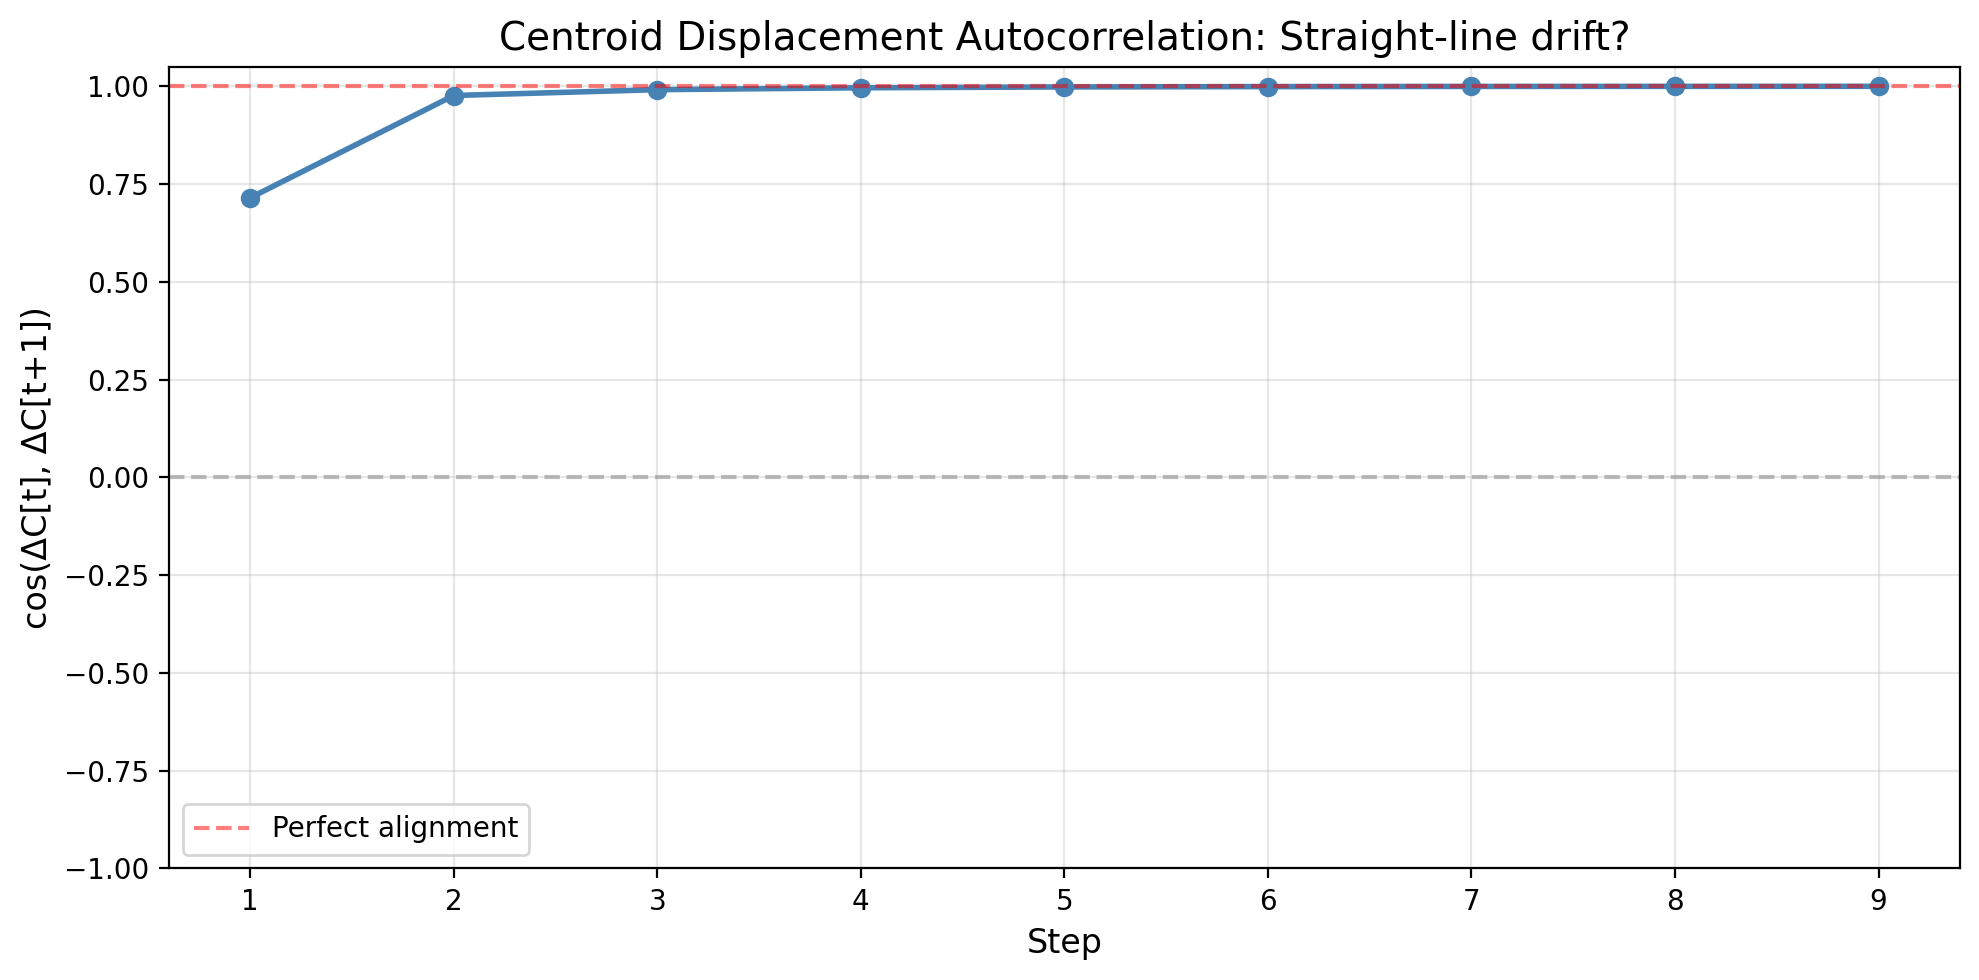

In [37]:
# Plot delta centroid autocorrelation
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(1, NUM_STEPS), centroid_autocorr.detach().numpy(), 'o-', color=STEELBLUE, linewidth=2, markersize=6)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Perfect alignment')
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('cos(ΔC[t], ΔC[t+1])', fontsize=12)
ax.set_title('Centroid Displacement Autocorrelation: Straight-line drift?', fontsize=14)
ax.set_ylim(-1, 1.05)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 3. h_mean vs Delta Centroid Correlation

Does h_mean[t] predict the direction of centroid motion?

In [38]:
# Compute cosine similarity between h_mean[t] and delta_centroid[t]
h_vs_centroid = torch.zeros(NUM_STEPS)
for t in range(NUM_STEPS):
    h_vs_centroid[t] = cosine_similarity(h_means[t], delta_centroids[t])

print("h_mean vs delta_centroid correlation:")
print(f"  Mean: {h_vs_centroid.mean().item():.6f}")
print(f"  Std: {h_vs_centroid.std().item():.6f}")
print(f"  Min: {h_vs_centroid.min().item():.6f}")
print(f"  Max: {h_vs_centroid.max().item():.6f}")
print(f"\n  (Expected: close to -1 since tokens move antiparallel to h)")

h_mean vs delta_centroid correlation:
  Mean: -0.907723
  Std: 0.053099
  Min: -0.968263
  Max: -0.806022

  (Expected: close to -1 since tokens move antiparallel to h)


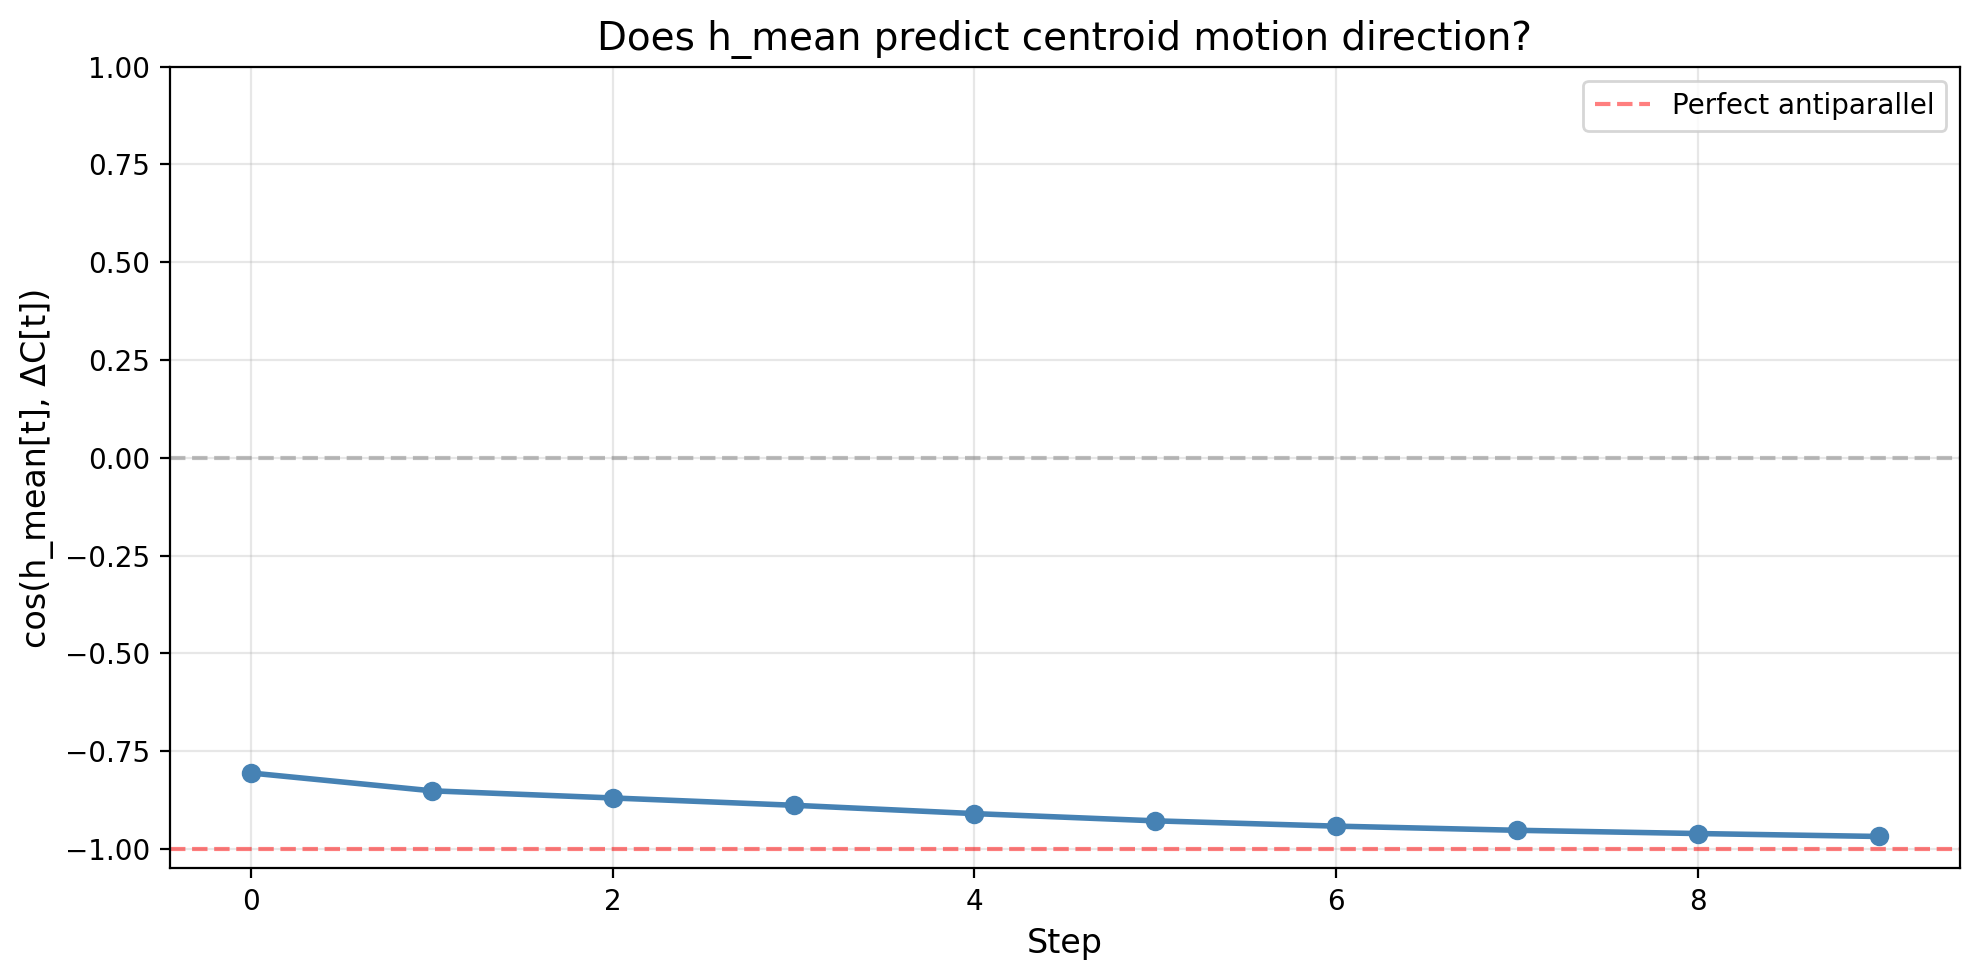

In [39]:
# Plot h_mean vs delta_centroid correlation
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(NUM_STEPS), h_vs_centroid.detach().numpy(), 'o-', color=STEELBLUE, linewidth=2, markersize=6)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=-1, color='red', linestyle='--', alpha=0.5, label='Perfect antiparallel')
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('cos(h_mean[t], ΔC[t])', fontsize=12)
ax.set_title('Does h_mean predict centroid motion direction?', fontsize=14)
ax.set_ylim(-1.05, 1)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 4. Individual Token Alignment with h_mean

How tightly does each token's displacement align with h_mean?

In [40]:
# For each step, compute cosine similarity between each token's delta_W and h_mean
token_h_alignment = torch.zeros(NUM_STEPS, n_dead)

for t in range(NUM_STEPS):
    h_t = h_means[t]  # [D]
    for i in range(n_dead):
        delta_w_i = delta_Ws[t, i]  # [D]
        token_h_alignment[t, i] = cosine_similarity(delta_w_i, h_t)

# Statistics across tokens at each step
token_h_mean = token_h_alignment.mean(dim=1)  # [num_steps]
token_h_std = token_h_alignment.std(dim=1)    # [num_steps]

print("Individual token alignment with h_mean:")
print(f"  Overall mean: {token_h_alignment.mean().item():.6f}")
print(f"  Overall std: {token_h_alignment.std().item():.6f}")
print(f"  Per-step mean range: [{token_h_mean.min().item():.6f}, {token_h_mean.max().item():.6f}]")

Individual token alignment with h_mean:
  Overall mean: -0.906089
  Overall std: 0.052587
  Per-step mean range: [-0.967827, -0.795761]


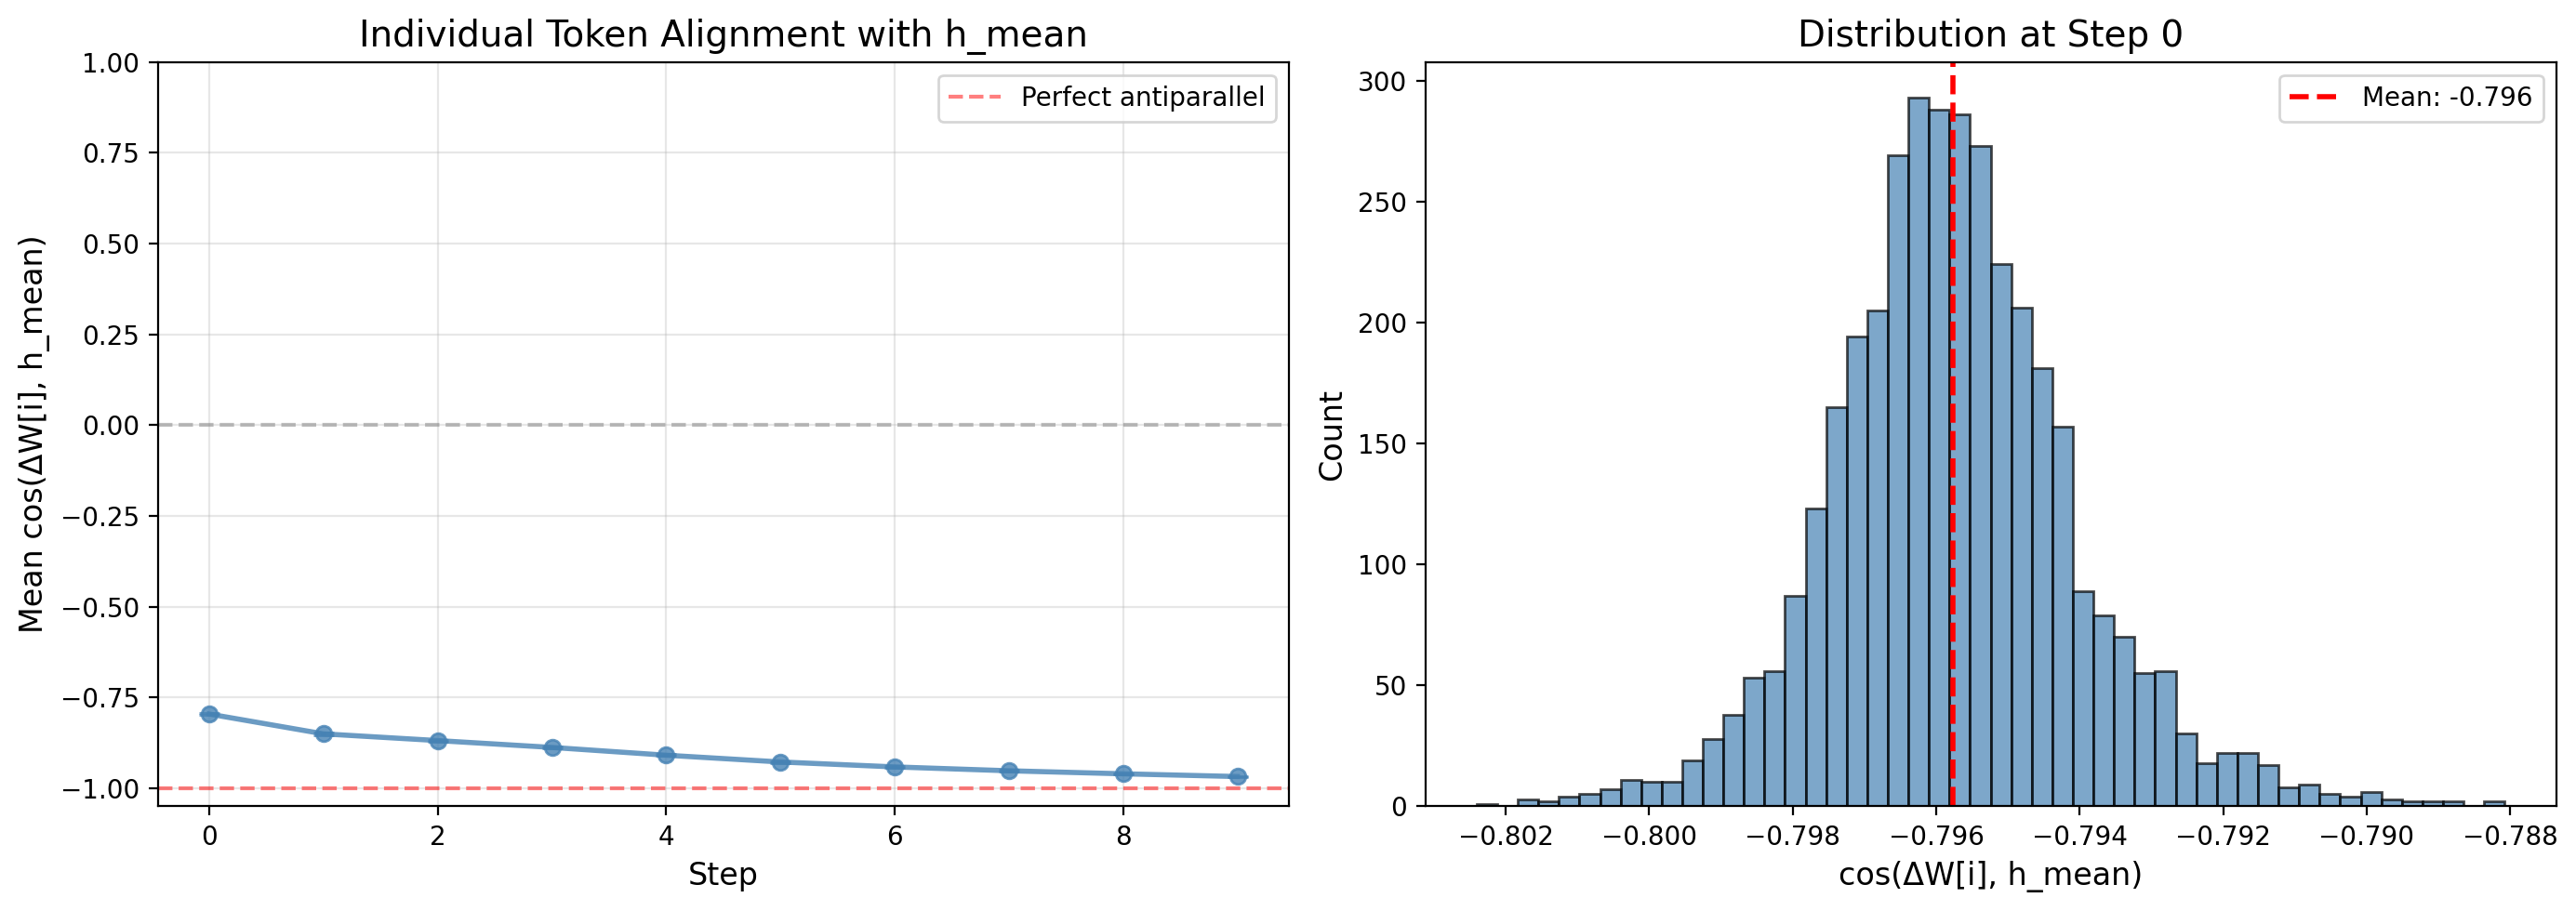

In [41]:
# Plot: Mean alignment over time with error bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Mean alignment per step
ax = axes[0]
ax.errorbar(range(NUM_STEPS), token_h_mean.detach().numpy(), yerr=token_h_std.detach().numpy(),
            fmt='o-', color=STEELBLUE, linewidth=2, markersize=6, capsize=4, alpha=0.8)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=-1, color='red', linestyle='--', alpha=0.5, label='Perfect antiparallel')
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Mean cos(ΔW[i], h_mean)', fontsize=12)
ax.set_title('Individual Token Alignment with h_mean', fontsize=14)
ax.set_ylim(-1.05, 1)
ax.grid(True, alpha=0.3)
ax.legend()

# Right: Distribution at first step (as example)
ax = axes[1]
ax.hist(token_h_alignment[0].detach().numpy(), bins=50, color=STEELBLUE, alpha=0.7, edgecolor='black')
ax.axvline(token_h_mean[0].item(), color='red', linestyle='--', linewidth=2, label=f'Mean: {token_h_mean[0].item():.3f}')
ax.set_xlabel('cos(ΔW[i], h_mean)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution at Step 0', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

## 5. Token-to-Token Displacement Coherence

How similar are individual token displacements to each other at each step?

In [42]:
# For each step, compute pairwise cosine similarities between all token displacements
# (This is expensive for large n_dead, so we'll sample if needed)

def token_coherence(delta_W):
    """
    Compute mean pairwise cosine similarity between token displacements.
    delta_W: [n_dead, D]
    """
    # Normalize all displacement vectors
    delta_W_norm = delta_W / delta_W.norm(dim=1, keepdim=True)  # [n_dead, D]
    
    # Compute pairwise cosine similarities (dot product of normalized vectors)
    # This is a [n_dead, n_dead] matrix
    cos_matrix = delta_W_norm @ delta_W_norm.T  # [n_dead, n_dead]
    
    # Extract upper triangle (exclude diagonal)
    upper_tri = torch.triu(cos_matrix, diagonal=1)
    
    # Mean of upper triangle
    n = delta_W.shape[0]
    mean_coherence = upper_tri.sum() / (n * (n - 1) / 2)
    
    return mean_coherence.item()

coherence_per_step = torch.zeros(NUM_STEPS)
for t in range(NUM_STEPS):
    coherence_per_step[t] = token_coherence(delta_Ws[t])

print("Token-to-token displacement coherence:")
print(f"  Mean: {coherence_per_step.mean().item():.6f}")
print(f"  Std: {coherence_per_step.std().item():.6f}")
print(f"  Min: {coherence_per_step.min().item():.6f}")
print(f"  Max: {coherence_per_step.max().item():.6f}")

Token-to-token displacement coherence:
  Mean: 0.996104
  Std: 0.007552
  Min: 0.974685
  Max: 0.999080


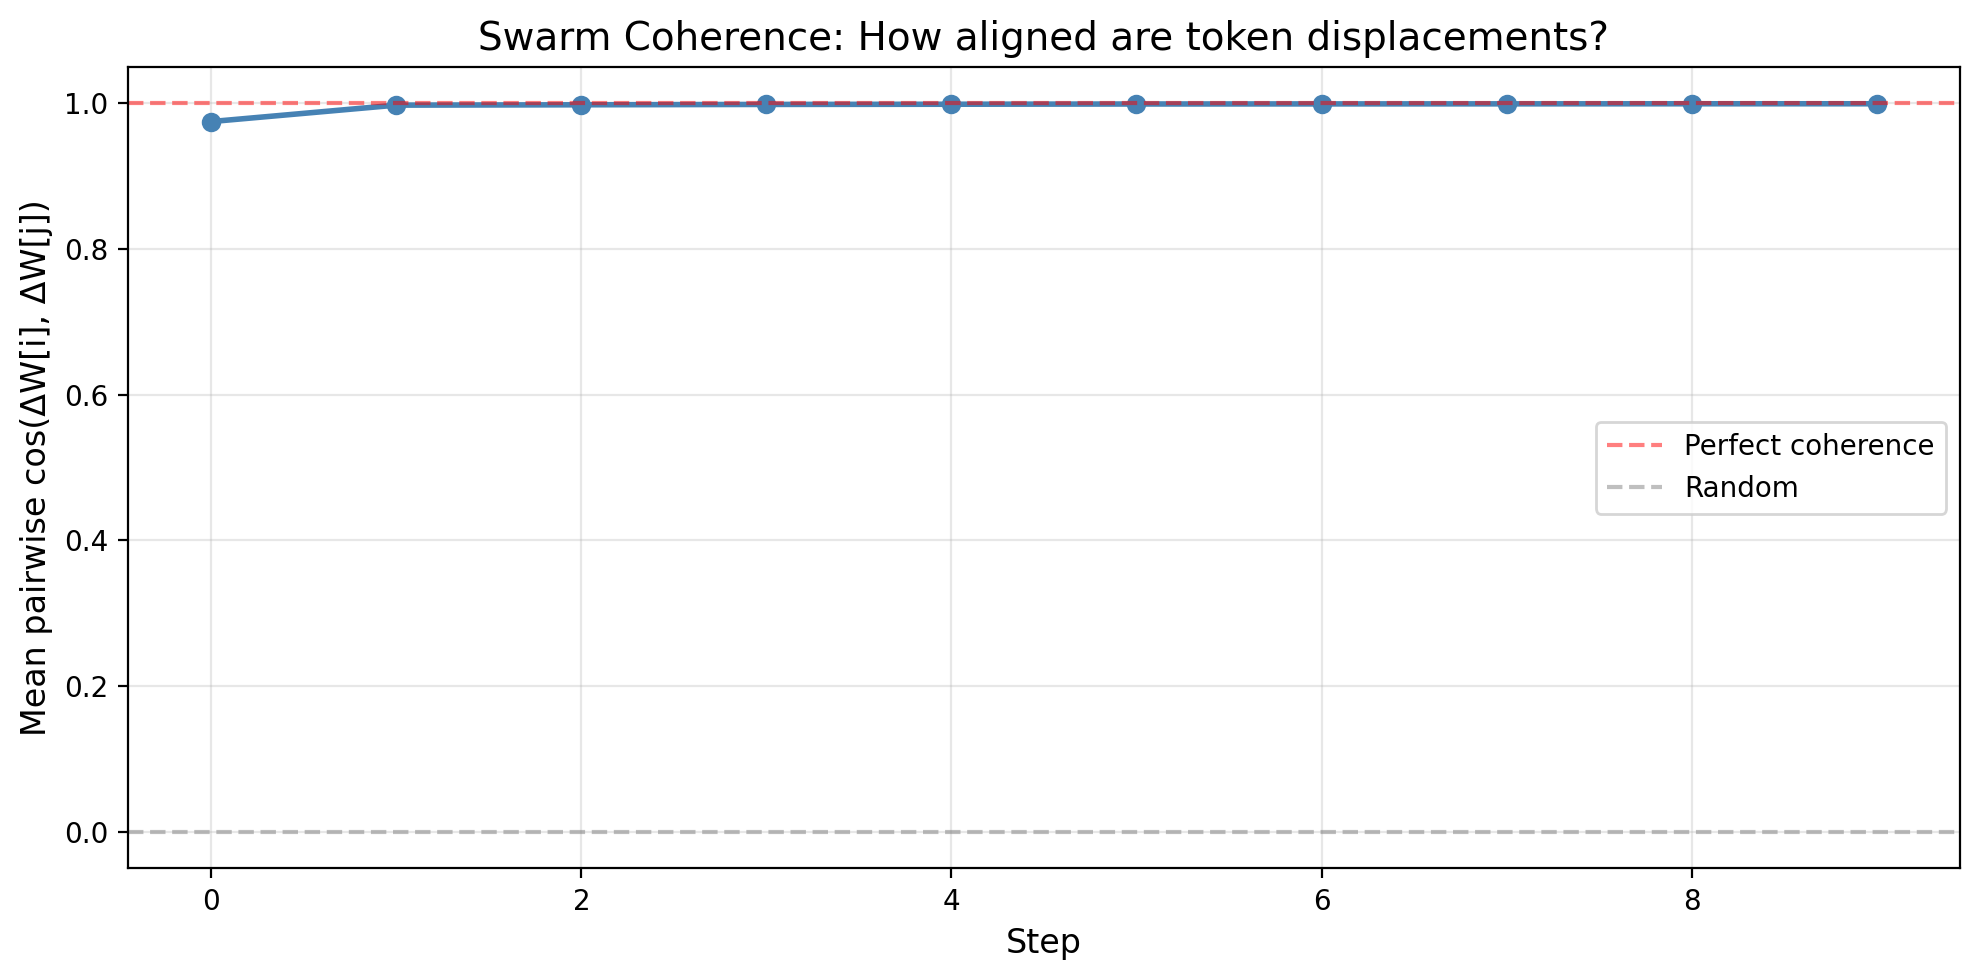

In [43]:
# Plot swarm coherence over time
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(NUM_STEPS), coherence_per_step.detach().numpy(), 'o-', color=STEELBLUE, linewidth=2, markersize=6)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Perfect coherence')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Random')
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Mean pairwise cos(ΔW[i], ΔW[j])', fontsize=12)
ax.set_title('Swarm Coherence: How aligned are token displacements?', fontsize=14)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

---

## Summary Statistics

In [44]:
print("=" * 70)
print("SUMMARY: h_mean AUTOCORRELATION AND CENTROID DYNAMICS")
print("=" * 70)
print(f"\nSteps analyzed: {NUM_STEPS}")
print(f"Dead tokens: {n_dead}")
print(f"\n--- 1. h_mean Autocorrelation ---")
print(f"  Mean cos(h[t], h[t+1]): {h_autocorr.mean().item():.6f} ± {h_autocorr.std().item():.6f}")
print(f"\n--- 2. Delta Centroid Autocorrelation ---")
print(f"  Mean cos(ΔC[t], ΔC[t+1]): {centroid_autocorr.mean().item():.6f} ± {centroid_autocorr.std().item():.6f}")
print(f"\n--- 3. h_mean vs Delta Centroid ---")
print(f"  Mean cos(h[t], ΔC[t]): {h_vs_centroid.mean().item():.6f} ± {h_vs_centroid.std().item():.6f}")
print(f"\n--- 4. Individual Token Alignment with h_mean ---")
print(f"  Mean cos(ΔW[i,t], h[t]): {token_h_alignment.mean().item():.6f} ± {token_h_alignment.std().item():.6f}")
print(f"\n--- 5. Token-to-Token Coherence ---")
print(f"  Mean pairwise cos(ΔW[i], ΔW[j]): {coherence_per_step.mean().item():.6f} ± {coherence_per_step.std().item():.6f}")
print("\n" + "=" * 70)

SUMMARY: h_mean AUTOCORRELATION AND CENTROID DYNAMICS

Steps analyzed: 10
Dead tokens: 3699

--- 1. h_mean Autocorrelation ---
  Mean cos(h[t], h[t+1]): 0.946846 ± 0.127315

--- 2. Delta Centroid Autocorrelation ---
  Mean cos(ΔC[t], ΔC[t+1]): 0.963804 ± 0.093710

--- 3. h_mean vs Delta Centroid ---
  Mean cos(h[t], ΔC[t]): -0.907723 ± 0.053099

--- 4. Individual Token Alignment with h_mean ---
  Mean cos(ΔW[i,t], h[t]): -0.906089 ± 0.052587

--- 5. Token-to-Token Coherence ---
  Mean pairwise cos(ΔW[i], ΔW[j]): 0.996104 ± 0.007552

